reference:
Introduction to Market Basket Analysis in Python
http://pbpython.com/market-basket-analysis.html

A Gentle Introduction on Market Basket Analysis — Association Rules in R
https://datascienceplus.com/a-gentle-introduction-on-market-basket-analysis%E2%80%8A-%E2%80%8Aassociation-rules/

https://towardsdatascience.com/a-gentle-introduction-on-market-basket-analysis-association-rules-fa4b986a40ce


Association rules and frequent itemsets
https://orange.readthedocs.io/en/latest/reference/rst/Orange.associate.html

Data set:Online Retail
http://archive.ics.uci.edu/ml/datasets/online+retail

Package: MLxtend (Apirior algorithm) or  Orange Documentation v2.7.6 and Orange3-Associate (FP-growth)

1.Install the orange package
conda config --add channels conda-forge
conda install orange3
or
pip install orange3
2.Install the orage package
maybe you need update or install the setpuptools and wheel
python -m pip install --upgrade pip setuptools wheel
pip install Orange3-Associate


In [1]:
import pandas as pd
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules
import matplotlib.pylab as plt
%matplotlib inline

The dataset we are using today comes from UCI Machine Learning repository. The dataset is called “Online Retail” and can be found here. It contains all the transactions occurring between 01/12/2010 and 09/12/2011 for a UK-based and registered online retailer.

In [2]:
df = pd.read_excel("Online Retail.xlsx")

In [3]:
df.head(10)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
5,536365,22752,SET 7 BABUSHKA NESTING BOXES,2,2010-12-01 08:26:00,7.65,17850.0,United Kingdom
6,536365,21730,GLASS STAR FROSTED T-LIGHT HOLDER,6,2010-12-01 08:26:00,4.25,17850.0,United Kingdom
7,536366,22633,HAND WARMER UNION JACK,6,2010-12-01 08:28:00,1.85,17850.0,United Kingdom
8,536366,22632,HAND WARMER RED POLKA DOT,6,2010-12-01 08:28:00,1.85,17850.0,United Kingdom
9,536367,84879,ASSORTED COLOUR BIRD ORNAMENT,32,2010-12-01 08:34:00,1.69,13047.0,United Kingdom


In [4]:
print("The shape of the data:{}".format(df.shape))
df.info()

The shape of the data:(541909, 8)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
InvoiceNo      541909 non-null object
StockCode      541909 non-null object
Description    540455 non-null object
Quantity       541909 non-null int64
InvoiceDate    541909 non-null datetime64[ns]
UnitPrice      541909 non-null float64
CustomerID     406829 non-null float64
Country        541909 non-null object
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


In [5]:
# df["Time"] = df.InvoiceDate.dt.time
# df.set_index('Time')['InvoiceNo'].resample(8).plot()

In [6]:
# df.head()

In [7]:
#tranform the negative value into positive
df.Quantity = df.Quantity.abs()
#grouped the data by each InvoiceNoe
grouped_df = df.groupby(['InvoiceNo']).agg({'Quantity':'sum'})

grouped_df.head()

,Quantity
InvoiceNo,
536365,40
536366,12
536367,83
536368,15
536369,3


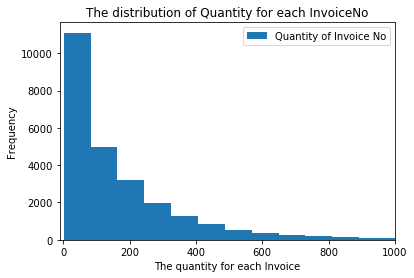

In [8]:
# The distribution of Quantity for each InvoiceNo
grouped_df.plot.hist(bins=1000)
plt.xlim([-10,1000])
plt.xlabel('The quantity for each Invoice')
plt.legend(['Quantity of Invoice No'])
plt.title("The distribution of Quantity for each InvoiceNo")

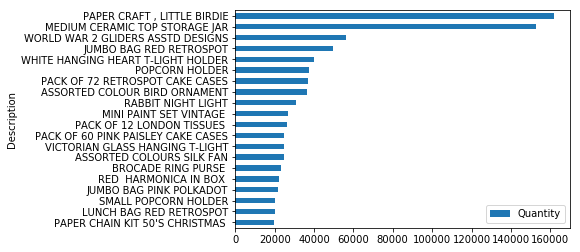

In [9]:
#The best 20 sellers
item_df = df.groupby(['StockCode','Description'],as_index=False).agg({'Quantity':'sum'})
item_df.set_index('Description').sort_values(by = 'Quantity',ascending = False)[0:20][::-1].plot.barh()
# item_df.Description.plot.barh()

## Data preprocessing

In [10]:
# Clean up spaces in description and remove any rows that don't have a valid invoice
df.Description = df.Description.str.strip()
df.dropna(axis=0, subset=['InvoiceNo'], inplace=True)
print('THe shape of dropna dataset:{}'.format(df.shape))

THe shape of dropna dataset:(541909, 8)


In [11]:
# remove the credit transactions (those with invoice numbers containing C)
df['InvoiceNo'] = df['InvoiceNo'].astype('str')
df = df[~df['InvoiceNo'].str.contains('C')]
df.shape

(532621, 8)

### One Hot Encoding
After the cleanup, we need to consolidate the items into 1 transaction per row with each product 1 hot encoded. 

In [12]:
#looking at sales for France and grouped by InvocieNo and Description
grouped_df = df[df['Country'] =="France"].groupby(['InvoiceNo', 'Description'])['Quantity'].sum()
#we get multiindex dataframe
grouped_df.head(10)

InvoiceNo  Description                    
536370     ALARM CLOCK BAKELIKE GREEN         12
           ALARM CLOCK BAKELIKE PINK          24
           ALARM CLOCK BAKELIKE RED           24
           CHARLOTTE BAG DOLLY GIRL DESIGN    20
           CIRCUS PARADE LUNCH BOX            24
           INFLATABLE POLITICAL GLOBE         48
           LUNCH BOX I LOVE LONDON            24
           MINI JIGSAW CIRCUS PARADE          24
           MINI JIGSAW SPACEBOY               24
           MINI PAINT SET VINTAGE             36
Name: Quantity, dtype: int64

In [13]:
#unstack the multipe index dataframe into single index
unstack_df = grouped_df.unstack()
#reset the index and fill the nan with o
fillna_df = unstack_df.reset_index().fillna(0)
#set the index with the column of InvoiceNO
basket_df = fillna_df.set_index('InvoiceNo')
basket_df.head(10)

Description,10 COLOUR SPACEBOY PEN,12 COLOURED PARTY BALLOONS,12 EGG HOUSE PAINTED WOOD,12 MESSAGE CARDS WITH ENVELOPES,12 PENCIL SMALL TUBE WOODLAND,12 PENCILS SMALL TUBE RED RETROSPOT,12 PENCILS SMALL TUBE SKULL,12 PENCILS TALL TUBE POSY,12 PENCILS TALL TUBE RED RETROSPOT,12 PENCILS TALL TUBE WOODLAND,...,WRAP VINTAGE PETALS DESIGN,YELLOW COAT RACK PARIS FASHION,YELLOW GIANT GARDEN THERMOMETER,YELLOW SHARK HELICOPTER,ZINC STAR T-LIGHT HOLDER,ZINC FOLKART SLEIGH BELLS,ZINC HERB GARDEN CONTAINER,ZINC METAL HEART DECORATION,ZINC T-LIGHT HOLDER STAR LARGE,ZINC T-LIGHT HOLDER STARS SMALL
InvoiceNo,,,,,,,,,,,,,,,,,,,,,
536370,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
536852,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
536974,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
537065,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
537463,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
537468,24.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
537693,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
537897,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
537967,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [14]:
#define a encode function to transform the values
#  need to make sure any positive values are converted to a 1 and anything less the 0 is set to 0. 
# This step will complete the one hot encoding of the data 
def encode_units(x):
    if x <= 0:
        return 0
    if x >= 1:
        return 1

basket_sets = basket_df.applymap(encode_units)

# and remove the postage column (since that charge is not one we wish to explore)
basket_sets.drop('POSTAGE', inplace=True, axis=1)
print('The shape of basket set:{}'.format(basket_sets.shape))
basket_sets.head()

The shape of basket set:(392, 1562)


Description,10 COLOUR SPACEBOY PEN,12 COLOURED PARTY BALLOONS,12 EGG HOUSE PAINTED WOOD,12 MESSAGE CARDS WITH ENVELOPES,12 PENCIL SMALL TUBE WOODLAND,12 PENCILS SMALL TUBE RED RETROSPOT,12 PENCILS SMALL TUBE SKULL,12 PENCILS TALL TUBE POSY,12 PENCILS TALL TUBE RED RETROSPOT,12 PENCILS TALL TUBE WOODLAND,...,WRAP VINTAGE PETALS DESIGN,YELLOW COAT RACK PARIS FASHION,YELLOW GIANT GARDEN THERMOMETER,YELLOW SHARK HELICOPTER,ZINC STAR T-LIGHT HOLDER,ZINC FOLKART SLEIGH BELLS,ZINC HERB GARDEN CONTAINER,ZINC METAL HEART DECORATION,ZINC T-LIGHT HOLDER STAR LARGE,ZINC T-LIGHT HOLDER STARS SMALL
InvoiceNo,,,,,,,,,,,,,,,,,,,,,
536370,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
536852,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
536974,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
537065,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
537463,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [15]:
# Now that the data is structured properly, we can generate frequent item sets that have a support of at least 8% 
# (this number was chosen so that I could get enough useful examples):
frequent_itemsets = apriori(basket_sets, min_support=0.08, use_colnames=True)

In [16]:
# The final step is to generate the rules with their corresponding support, confidence and lift:
rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=0.5)
rules.head()

,antecedants,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(PLASTERS IN TIN CIRCUS PARADE),(PLASTERS IN TIN SPACEBOY),0.168367,0.137755,0.089286,0.530303,3.849607,0.066092,1.835747
1,(PLASTERS IN TIN SPACEBOY),(PLASTERS IN TIN CIRCUS PARADE),0.137755,0.168367,0.089286,0.648148,3.849607,0.066092,2.363588
2,(PLASTERS IN TIN CIRCUS PARADE),(PLASTERS IN TIN WOODLAND ANIMALS),0.168367,0.170918,0.102041,0.606061,3.545907,0.073264,2.104592
3,(PLASTERS IN TIN WOODLAND ANIMALS),(PLASTERS IN TIN CIRCUS PARADE),0.170918,0.168367,0.102041,0.597015,3.545907,0.073264,2.063681
4,(PLASTERS IN TIN WOODLAND ANIMALS),(PLASTERS IN TIN SPACEBOY),0.170918,0.137755,0.104592,0.611940,4.442233,0.081047,2.221939


In [17]:
import networkx as nx
import numpy as np

In [18]:
def draw_graph(rules, rules_to_show):
    G1 = nx.DiGraph()

    color_map=[]
    N = 50
    colors = np.random.rand(N)    
    strs=['R0', 'R1', 'R2', 'R3', 'R4', 'R5', 'R6', 'R7', 'R8', 'R9', 'R10', 'R11']   


    for i in range (rules_to_show):      
        G1.add_nodes_from(["R"+str(i)])
        for a in rules.iloc[i]['antecedants']:
            G1.add_nodes_from([a])
            G1.add_edge(a, "R"+str(i), color=colors[i] , weight = 2)
        for c in rules.iloc[i]['consequents']:
            G1.add_nodes_from([c])
            G1.add_edge("R"+str(i), c, color=colors[i],  weight=2)

    for node in G1:
        found_a_string = False
        for item in strs: 
            if node==item:
                found_a_string = True
        if found_a_string:
            color_map.append('yellow')
        else:
            color_map.append('green')       



    edges = G1.edges()
    colors = [G1[u][v]['color'] for u,v in edges]
    weights = [G1[u][v]['weight'] for u,v in edges]

    pos = nx.spring_layout(G1, k=16, scale=1)
    nx.draw(G1, pos, edges=edges, node_color = color_map, edge_color=colors, width=weights, font_size=16, with_labels=False)            

    for p in pos:  # raise text positions
           pos[p][1] += 0.07
    nx.draw_networkx_labels(G1, pos)
    plt.show()

C:\ProgramData\Anaconda2\envs\python36\lib\site-packages\networkx\drawing\nx_pylab.py:126: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  b = plt.ishold()
C:\ProgramData\Anaconda2\envs\python36\lib\site-packages\networkx\drawing\nx_pylab.py:138: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  plt.hold(b)
C:\ProgramData\Anaconda2\envs\python36\lib\site-packages\matplotlib\__init__.py:917: UserWarning: axes.hold is deprecated. Please remove it from your matplotlibrc and/or style files.
  warnings.warn(self.msg_depr_set % key)
C:\ProgramData\Anaconda2\envs\python36\lib\site-packages\matplotlib\rcsetup.py:152: UserWarning: axes.hold is deprecated, will be removed in 3.0
  wa

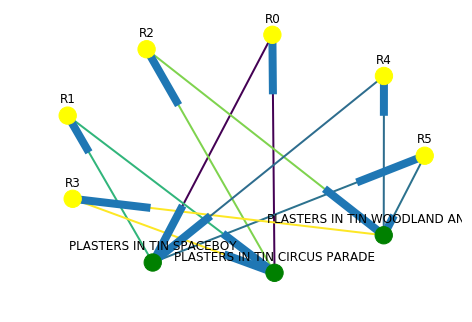

In [19]:
draw_graph(rules,6)
# plt.show()

In the above example, the {Diaper} is the antecedent and the {Beer} is the consequent. Both antecedents and consequents can have multiple items. In other words, {Diaper, Gum} -> {Beer, Chips} is a valid rule.

Support is the relative frequency that the rules show up. In many instances, you may want to look for high support in order to make sure it is a useful relationship. However, there may be instances where a low support is useful if you are trying to find “hidden” relationships.

Confidence is a measure of the reliability of the rule. A confidence of .5 in the above example would mean that in 50% of the cases where Diaper and Gum were purchased, the purchase also included Beer and Chips. For product recommendation, a 50% confidence may be perfectly acceptable but in a medical situation, this level may not be high enough.

Lift is the ratio of the observed support to that expected if the two rules were independent (see wikipedia). The basic rule of thumb is that a lift value close to 1 means the rules were completely independent. Lift values > 1 are generally more “interesting” and could be indicative of a useful rule pattern.

 For instance, we can see that there are quite a few rules with a high lift value which means that it occurs more frequently than would be expected given the number of transaction and product combinations. We can also see several where the confidence is high as well. This part of the analysis is where the domain knowledge will come in handy. Since I do not have that, I’ll just look for a couple of illustrative examples.

In [20]:
rules[ (rules['confidence'] >= 0.8) ]

,antecedants,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
8,(SET/6 RED SPOTTY PAPER PLATES),(SET/20 RED RETROSPOT PAPER NAPKINS),0.127551,0.132653,0.102041,0.800000,6.030769,0.085121,4.336735
10,(SET/6 RED SPOTTY PAPER PLATES),(SET/6 RED SPOTTY PAPER CUPS),0.127551,0.137755,0.122449,0.960000,6.968889,0.104878,21.556122
11,(SET/6 RED SPOTTY PAPER CUPS),(SET/6 RED SPOTTY PAPER PLATES),0.137755,0.127551,0.122449,0.888889,6.968889,0.104878,7.852041
12,"(SET/6 RED SPOTTY PAPER CUPS, SET/6 RED SPOTTY...",(SET/20 RED RETROSPOT PAPER NAPKINS),0.122449,0.132653,0.099490,0.812500,6.125000,0.083247,4.625850
13,"(SET/20 RED RETROSPOT PAPER NAPKINS, SET/6 RED...",(SET/6 RED SPOTTY PAPER CUPS),0.102041,0.137755,0.099490,0.975000,7.077778,0.085433,34.489796
14,"(SET/20 RED RETROSPOT PAPER NAPKINS, SET/6 RED...",(SET/6 RED SPOTTY PAPER PLATES),0.102041,0.127551,0.099490,0.975000,7.644000,0.086474,34.897959


In looking at the rules, it seems that the green and red alarm clocks are purchased together and the red paper cups, napkins and plates are purchased together in a manner that is higher than the overall probability would suggest.

At this point, you may want to look at how much opportunity there is to use the popularity of one product to drive sales of another. For instance, we can see that we sell 340 Green Alarm clocks but only 316 Red Alarm Clocks so maybe we can drive more Red Alarm Clock sales through recommendations?

In [21]:
basket['ALARM CLOCK BAKELIKE GREEN'].sum()

NameError: name 'basket' is not defined

In [ ]:
basket['ALARM CLOCK BAKELIKE RED'].sum()

In [ ]:
basket2 = (df[df['Country'] =="Germany"]
          .groupby(['InvoiceNo', 'Description'])['Quantity']
          .sum().unstack().reset_index().fillna(0)
          .set_index('InvoiceNo'))

basket_sets2 = basket2.applymap(encode_units)
basket_sets2.drop('POSTAGE', inplace=True, axis=1)
frequent_itemsets2 = apriori(basket_sets2, min_support=0.05, use_colnames=True)
rules2 = association_rules(frequent_itemsets2, metric="lift", min_threshold=1)

rules2[ (rules2['lift'] >= 4) &
        (rules2['confidence'] >= 0.5)]